In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels,in_channels,3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels,in_channels,3),
            nn.InstanceNorm2d(in_channels)
        )
    def forward(self, x):
        return x + self.block(x)

In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet,self).__init__()

        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels,out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        channels = out_channels

        self.down = []

        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)

        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)

        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x


In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

In [5]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [6]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
count_parameters(D_B)

2764737

In [9]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


In [10]:
import itertools
lr = 0.0005
b1 = 0.5
b2 = 0.996

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2)
)

In [11]:
n_epoches = 150
decay_epoch = 15

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

In [12]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')
        
        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_A)
    
    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]
        
        img_A = Image.open(file_A)
        img_B = Image.open(file_B)
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B

In [13]:
import torchvision.transforms as transforms

data_dir = '/kaggle/input/gan-getting-started'

transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 2

trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

testloader = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0
)


C:\Users\kdy\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\kdy\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [14]:
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

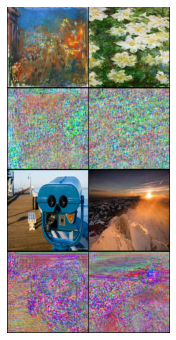

In [15]:
real_A, real_B = next(iter(testloader))
sample_images(real_A, real_B)

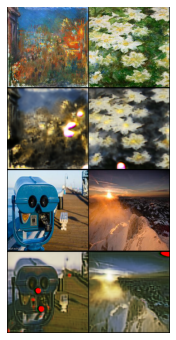

[Epoch 10/150]
[G loss: 4.559995174407959 | identity: 0.3104887008666992 GAN: 0.31930291652679443 cycle: 0.26882487535476685]
[D loss: 0.15726996958255768 | D_A: 0.23742829263210297 D_B: 0.0771116390824318]


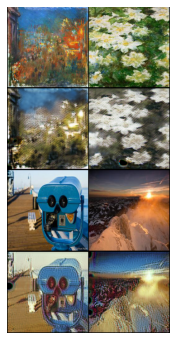

[Epoch 20/150]
[G loss: 5.145389556884766 | identity: 0.2641557455062866 GAN: 1.1906929016113281 cycle: 0.26339179277420044]
[D loss: 0.08099555969238281 | D_A: 0.08814739435911179 D_B: 0.07384373247623444]


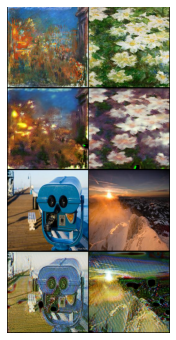

[Epoch 30/150]
[G loss: 3.79290771484375 | identity: 0.1933087259531021 GAN: 0.8295060992240906 cycle: 0.19968578219413757]
[D loss: 0.10849415510892868 | D_A: 0.07735930383205414 D_B: 0.13962900638580322]


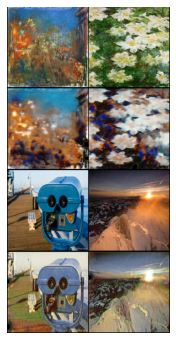

[Epoch 40/150]
[G loss: 4.090226650238037 | identity: 0.22623974084854126 GAN: 1.0048978328704834 cycle: 0.1954130232334137]
[D loss: 0.04194006323814392 | D_A: 0.03974360227584839 D_B: 0.04413652420043945]


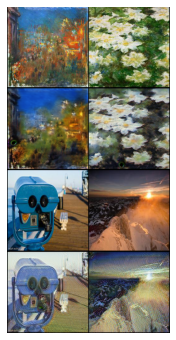

[Epoch 50/150]
[G loss: 3.923487901687622 | identity: 0.24866782128810883 GAN: 0.5522239208221436 cycle: 0.21279248595237732]
[D loss: 0.17271175980567932 | D_A: 0.15128517150878906 D_B: 0.19413834810256958]


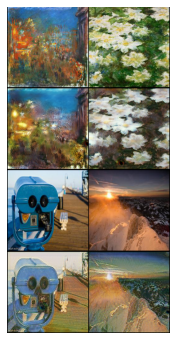

[Epoch 60/150]
[G loss: 4.346597194671631 | identity: 0.23546156287193298 GAN: 0.7211195230484009 cycle: 0.24481700360774994]
[D loss: 0.21825236082077026 | D_A: 0.3408087193965912 D_B: 0.09569598734378815]


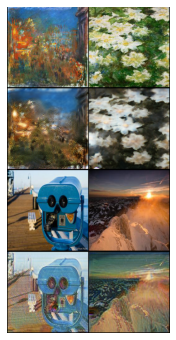

[Epoch 70/150]
[G loss: 3.5214648246765137 | identity: 0.2187873125076294 GAN: 0.5448894500732422 cycle: 0.1882638931274414]
[D loss: 0.0684015303850174 | D_A: 0.05924272537231445 D_B: 0.07756033539772034]


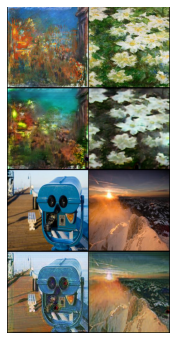

[Epoch 80/150]
[G loss: 3.775524616241455 | identity: 0.21577097475528717 GAN: 0.8924102783203125 cycle: 0.18042594194412231]
[D loss: 0.02053435519337654 | D_A: 0.01874006912112236 D_B: 0.022328639402985573]


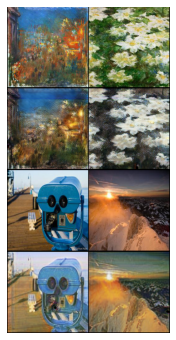

[Epoch 90/150]
[G loss: 2.7939858436584473 | identity: 0.15039509534835815 GAN: 0.8361139297485352 cycle: 0.12058962881565094]
[D loss: 0.03387732058763504 | D_A: 0.013277053833007812 D_B: 0.05447758361697197]


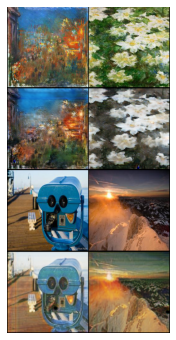

[Epoch 100/150]
[G loss: 2.7583210468292236 | identity: 0.13408446311950684 GAN: 0.9127655625343323 cycle: 0.11751332879066467]
[D loss: 0.02013779617846012 | D_A: 0.014896927401423454 D_B: 0.025378664955496788]


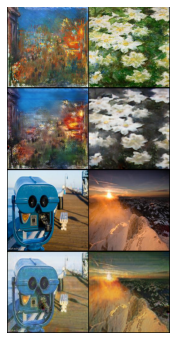

[Epoch 110/150]
[G loss: 2.8449435234069824 | identity: 0.13817647099494934 GAN: 0.8198573589324951 cycle: 0.13342037796974182]
[D loss: 0.03266943246126175 | D_A: 0.01477588340640068 D_B: 0.05056297779083252]


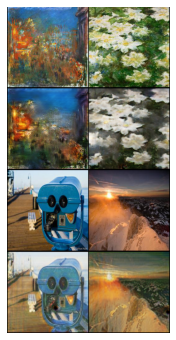

[Epoch 120/150]
[G loss: 3.0776796340942383 | identity: 0.16481010615825653 GAN: 0.9580649137496948 cycle: 0.12955641746520996]
[D loss: 0.012659432366490364 | D_A: 0.0090973861515522 D_B: 0.016221478581428528]


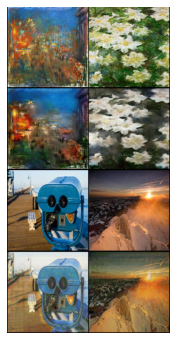

[Epoch 130/150]
[G loss: 2.814246654510498 | identity: 0.1418432593345642 GAN: 0.9592188596725464 cycle: 0.1145811453461647]
[D loss: 0.01923508569598198 | D_A: 0.008195275440812111 D_B: 0.030274897813796997]


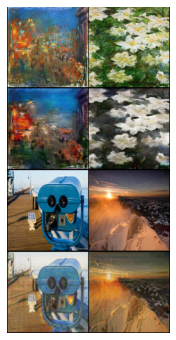

[Epoch 140/150]
[G loss: 2.6717705726623535 | identity: 0.12608955800533295 GAN: 1.1131259202957153 cycle: 0.0928196907043457]
[D loss: 0.015337278135120869 | D_A: 0.006649764254689217 D_B: 0.02402479201555252]


KeyboardInterrupt: 

In [16]:
for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(trainloader):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # test
    if (epoch+1) % 10 == 0:
        test_real_A, test_real_B = next(iter(testloader))
        sample_images(test_real_A, test_real_B)

        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')    

In [17]:
PATH = './weights/'

In [19]:
torch.save(G_AB, PATH + 'G_AB.pt')
torch.save(D_B, PATH + 'D_B.pt')
torch.save(G_BA, PATH + 'G_BA.pt')
torch.save(D_A, PATH + 'D_A.pt')